In [ ]:
## For this assignment, we plan on using the steam game data to predict whether a user would play a game or not


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gzip
from collections import defaultdict
import random
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt

def readGz(path):
  for l in gzip.open(path, 'rt'):
    yield eval(l)

def readCSV(path):
  f = gzip.open(path, 'rt')
  f.readline()
  for l in f:
    yield l.strip().split(',')

file_path = "/content/drive/My Drive/CSE158 SHARED/australian_users_items.json.gz"
#f = gzip.open("/content/australian_users_items.json.gz")
f = gzip.open(file_path)
dataset = []
for l in readGz(file_path):
    dataset.append(l)

In [ ]:
file_path = "/content/drive/My Drive/CSE158 SHARED/steam_games.json.gz"
f = gzip.open(file_path)
dataset_steam_games = []
for l in readGz(file_path):
    dataset_steam_games.append(l)

In [ ]:
dataset[0]

{'user_id': '76561197970982479',
 'items_count': 277,
 'steam_id': '76561197970982479',
 'user_url': 'http://steamcommunity.com/profiles/76561197970982479',
 'items': [{'item_id': '10',
   'item_name': 'Counter-Strike',
   'playtime_forever': 6,
   'playtime_2weeks': 0},
  {'item_id': '20',
   'item_name': 'Team Fortress Classic',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '30',
   'item_name': 'Day of Defeat',
   'playtime_forever': 7,
   'playtime_2weeks': 0},
  {'item_id': '40',
   'item_name': 'Deathmatch Classic',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '50',
   'item_name': 'Half-Life: Opposing Force',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '60',
   'item_name': 'Ricochet',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '70',
   'item_name': 'Half-Life',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '130',
   'item_name': 'Half-Life: Blue Shift',
   'playtime_forever

In [ ]:
dataset_steam_games[4]

{'app_name': 'Log Challenge',
 'tags': ['Action', 'Indie', 'Casual', 'Sports'],
 'url': 'http://store.steampowered.com/app/773570/Log_Challenge/',
 'price': 2.99,
 'discount_price': 1.79,
 'reviews_url': 'http://steamcommunity.com/app/773570/reviews/?browsefilter=mostrecent&p=1',
 'id': '773570',
 'early_access': False,
 'specs': ['Single-player',
  'Full controller support',
  'HTC Vive',
  'Oculus Rift',
  'Tracked Motion Controllers',
  'Room-Scale']}

In [ ]:
##Training data set and testing dataset
userTrain = dataset
#userTrain = dataset[:int(len(dataset)*0.8)]
#userTest = dataset[int(len(dataset)*0.8):]

gameTrain = dataset_steam_games
#gameTrain = dataset_steam_games[:int(len(dataset_steam_games)*0.8)]
#gameTest = dataset_steam_games[int(len(dataset_steam_games)*0.8):]

In [ ]:
gamesPerUser = defaultdict(list) #👍
hoursPerGame = {} #mostpopular all time
hoursPerGame2weeks = {} #mostpopular in the past 2 weeks
genrePerGamePerUser = defaultdict(list)
tagsPerGamePerUser = defaultdict(list)
hoursPerGamePerUser = defaultdict(list)##List of sets users: (game, hours) #👍
specsPerGamePerUser = defaultdict(list)
pricePerGamePerUser = defaultdict(float)
sentimentPerGameperUser = defaultdict(list) ##List of sets users: (game, sentiment)
hoursPerGenrePerUser = defaultdict(lambda: defaultdict(int))

positive_samples = []
negative_samples = []

# To generate negative samples, we need a set of all user-item interactions
all_items = set(item['item_name'] for user in userTrain for item in user['items'])
interaction_set = set()  # Keeps track of all user-item interactions


In [ ]:
games = []
genreperGame = {}
specsperGame = {}
tagsperGame = {}
sentimentperGame = {}
priceperGame = {}
for i in gameTrain:
  if 'app_name' in i:
    games.append(i['app_name'])
    if 'genres' in i:
      genreperGame[i['app_name']] = i['genres']
    else:
      genreperGame[i['app_name']] = []
    if 'specs' in i:
      specsperGame[i['app_name']] = i['specs']
    else:
      specsperGame[i['app_name']] = []
    if 'tags' in i:
      tagsperGame[i['app_name']] = i['tags']
    else:
      tagsperGame[i['app_name']] = []
    if 'sentiment' in i:
      sentimentperGame[i['app_name']] = i['sentiment']
    else:
      sentimentperGame[i['app_name']] = []
    if 'price' in i:
      priceperGame[i['app_name']] = i['price']
    else:
      priceperGame[i['app_name']] = []

In [ ]:
for i in userTrain:
  items = i['items']
  #random.shuffle(items)  # Shuffle the items to ensure randomness
  split_idx = int(len(items) * 0.80) #split game each user
  for j in items[:split_idx]:
    if j['item_name'] not in genreperGame:
      continue
    #positive_samples.append((i['user_id'], j['item_name'], "train"))
    interaction_set.add((i['user_id'], j['item_name']))
    hoursPerGamePerUser[i['user_id']].append((j['item_name'], j['playtime_forever']))
    if j['item_name'] not in hoursPerGame:
      hoursPerGame[j['item_name']] = 0
    hoursPerGame[j['item_name']] += int(j['playtime_forever'])
    if j['item_name'] not in hoursPerGame2weeks:
      hoursPerGame2weeks[j['item_name']] = 0
    hoursPerGame2weeks[j['item_name']] += int(j['playtime_2weeks'])
    if j['item_name'] in genreperGame:
      genrePerGamePerUser[i['user_id']].append((j['item_name'], genreperGame[j['item_name']]))
    else:
      genrePerGamePerUser[i['user_id']].append((j['item_name'], ''))
    # Update hoursPerGenrePerUser (hours per genre for each user)
    genres = genreperGame.get(j['item_name'], [])
    for genre in genres:
        hoursPerGenrePerUser[i['user_id']][genre] += int(j['playtime_2weeks'])  # Add the playtime to the corresponding genre

  for j in items[split_idx:]:
    if j['item_name'] not in genreperGame:
      continue
    positive_samples.append((i['user_id'], j['item_name'], "test"))
    interaction_set.add((i['user_id'], j['item_name']))
    genres = genreperGame.get(j['item_name'], [])
    for genre in genres:
      hoursPerGenrePerUser[i['user_id']][genre] += int(j['playtime_2weeks'])  # Add the playtime to the corresponding genre

In [ ]:
import random

def generate_negative_samples(i, items, split_idx, all_items, interaction_set):
    # Step 1: Precompute possible negative items (those that the user hasn't interacted with)
    user_interacted_items = set([item['item_name'] for item in items[split_idx:]])  # Items in the test set
    possible_negative_items = set(all_items) - user_interacted_items

    # Step 2: Precompute the list of negative samples for the user (without any checks)
    negative_samples_candidate = [(i['user_id'], item) for item in possible_negative_items]

    # Step 3: Shuffle the list of negative samples (for randomness)
    random.shuffle(negative_samples_candidate)

    # Step 4: Select the same number of negative samples as the number of positive samples
    positive_samples_count = len(items[split_idx:])
    negative_samples = negative_samples_candidate[:positive_samples_count]

    # Step 5: Add negative samples to the interaction set and ensure they are unique
    interaction_set.update(negative_samples)

    return negative_samples  # Return the list of negative samples for this user

# Example usage:
#userTrain = [...]  # List of user data
#all_items = [...]   # List of all items
#split_idx = int(len(userTrain[0]['items']) * 0.8)  # Example split index

#negative_samples = []
#interaction_set = set()  # Set to keep track of interactions

for i in userTrain:
    items = i['items']
    split_idx = int(len(items) * 0.80)
    negative_samples_for_user = generate_negative_samples(i, i['items'], split_idx, all_items, interaction_set)
    negative_samples.extend(negative_samples_for_user)

# negative_samples now contains the negative samples for all users
# interaction_set contains all interactions, including negative ones


In [ ]:
# print(positive_samples.pop())


In [ ]:
# print(negative_samples.pop())
genreperGame

{'Lost Summoner Kitty': ['Action',
  'Casual',
  'Indie',
  'Simulation',
  'Strategy'],
 'Ironbound': ['Free to Play', 'Indie', 'RPG', 'Strategy'],
 'Real Pool 3D - Poolians': ['Casual',
  'Free to Play',
  'Indie',
  'Simulation',
  'Sports'],
 '弹炸人2222': ['Action', 'Adventure', 'Casual'],
 'Log Challenge': [],
 'Battle Royale Trainer': ['Action', 'Adventure', 'Simulation'],
 'SNOW - All Access Basic Pass': ['Free to Play',
  'Indie',
  'Simulation',
  'Sports'],
 'SNOW - All Access Pro Pass': ['Free to Play',
  'Indie',
  'Simulation',
  'Sports'],
 'SNOW - All Access Legend Pass': ['Free to Play',
  'Indie',
  'Simulation',
  'Sports'],
 'Race': ['Casual', 'Indie', 'Racing', 'Simulation'],
 'Uncanny Islands': ['Action', 'Indie', 'Simulation', 'Early Access'],
 'Icarus Six Sixty Six': [],
 'Army of Tentacles: (Not) A Cthulhu Dating Sim: Black GOAT of the Woods Edition': ['Action',
  'Adventure',
  'Casual',
  'Indie',
  'RPG'],
 'Beach Rules': ['Casual', 'Indie'],
 'Planetarium 2 - 

In [ ]:
genrePerGamePerUser['76561198329548331']

[('Unturned', ['Action', 'Adventure', 'Casual', 'Free to Play', 'Indie']),
 ('Heroes & Generals',
  ['Action', 'Free to Play', 'Indie', 'Massively Multiplayer']),
 ('BrainBread 2',
  ['Action', 'Adventure', 'Free to Play', 'Indie', 'Early Access']),
 ('All Is Dust', []),
 ('One Way To Die: Steam Edition', ['Adventure', 'Free to Play'])]

In [ ]:
hoursPerGamePerUser

defaultdict(list,
            {'76561197970982479': [('Counter-Strike', 6),
              ('Team Fortress Classic', 0),
              ('Day of Defeat', 7),
              ('Deathmatch Classic', 0),
              ('Half-Life: Opposing Force', 0),
              ('Ricochet', 0),
              ('Half-Life', 0),
              ('Half-Life: Blue Shift', 0),
              ('Day of Defeat: Source', 4733),
              ('Counter-Strike: Source', 1853),
              ('Psychonauts', 333),
              ("Sid Meier's Pirates!", 2),
              ('Joint Task Force', 286),
              ('Deus Ex: Game of the Year Edition', 2685),
              ('Half-Life 2', 696),
              ('Half-Life 2: Deathmatch', 0),
              ('Half-Life 2: Lost Coast', 37),
              ('Half-Life Deathmatch: Source', 0),
              ('Half-Life 2: Episode One', 168),
              ('Portal', 173),
              ('Half-Life 2: Episode Two', 323),
              ('Unreal Gold', 0),
              ('Virtual Village

In [ ]:
hoursPerGame = sorted_by_values_desc = dict(sorted(hoursPerGame.items(), key=lambda item: item[1], reverse=True)) #aka mostpopular
hoursPerGame2weeks = sorted_by_values_desc = dict(sorted(hoursPerGame2weeks.items(), key=lambda item: item[1], reverse=True)) #aka mostpopular in the past 2 weeks

In [ ]:
hoursPerGame2weeks
len(hoursPerGame2weeks)

7257

In [ ]:
print(len(genreperGame))
print(len(games))

32094
32133


In [ ]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom > 0:
        return numer/denom
    return 0

In [ ]:
### Baseline predictions (1) -
def base_prediction(user, game):
  usergenres_per_game = genrePerGamePerUser[user]
  game_genre = genreperGame[game]
  if game_genre == []:
    return 0
  acc = 0
  sim_count = 0
  acc_counts = []

  for game,gamesGenre in usergenres_per_game:
    count = 0
    for genre in game_genre:
      if genre in gamesGenre:
        count += 1
    acc_counts.append(count/len(game_genre))
  if len(acc_counts) == 0:
    return 0
  acc = sum(acc_counts) / len(acc_counts)
  if acc > 0.5:
    return 1
  return 0

In [ ]:
base_prediction("76561198329548331", 'BrainBread 2')

1

In [ ]:
correct = 0
total = 0
for (label, samples) in [(1, positive_samples), (0, negative_samples)]:
    for user_id, item_name, *_ in samples:  # Unpack only relevant fields
        pred = base_prediction(user_id, item_name)
        if pred == label:
            correct += 1
        total += 1
accuracy = correct / total
print(f"Accuracy: {accuracy:.2%}")

KeyboardInterrupt: 

In [ ]:
correct_counts = {1: 0, 0: 0}
total_counts = {1: 0, 0: 0}

# Evaluate predictions
for (label, samples) in [(1, positive_samples), (0, negative_samples)]:
    for user_id, item_name, *_ in samples:
        pred = base_prediction(user_id, item_name)  # Predict interaction
        if pred == label:
            correct_counts[label] += 1
        total_counts[label] += 1

# Calculate accuracy
accuracies = {
    label: (correct_counts[label] / total_counts[label] if total_counts[label] > 0 else 0)
    for label in [1, 0]
}

# Plot the results
labels = ['Positive Samples', 'Negative Samples']
values = [accuracies[1], accuracies[0]]

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.title("Prediction Accuracy for Positive and Negative Samples")
plt.ylabel("Accuracy")
plt.xlabel("Sample Type")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

KeyError: 'Perraw - FPS Clone War'

In [ ]:
# Calculate individual accuracies
accuracies = {
    label: (correct_counts[label] / total_counts[label] if total_counts[label] > 0 else 0)
    for label in [1, 0]
}

# Calculate combined accuracy
total_correct = sum(correct_counts.values())
total_samples = sum(total_counts.values())
combined_accuracy = total_correct / total_samples if total_samples > 0 else 0

# Data for plotting
categories = ['Positive Samples', 'Negative Samples', 'Combined']
values = [accuracies[1], accuracies[0], combined_accuracy]

# Plot the results
plt.figure(figsize=(8, 5))
plt.bar(categories, values, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)
plt.title("Prediction Accuracy for Positive, Negative, and Combined Samples")
plt.ylabel("Accuracy")
plt.xlabel("Sample Type")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display values above bars
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center')

plt.show()

dict_items([('Lost Summoner Kitty', ['Single-player']), ('Ironbound', ['Single-player', 'Multi-player', 'Online Multi-Player', 'Cross-Platform Multiplayer', 'Steam Achievements', 'Steam Trading Cards', 'In-App Purchases']), ('Real Pool 3D - Poolians', ['Single-player', 'Multi-player', 'Online Multi-Player', 'In-App Purchases', 'Stats']), ('弹炸人2222', ['Single-player']), ('Log Challenge', ['Single-player', 'Full controller support', 'HTC Vive', 'Oculus Rift', 'Tracked Motion Controllers', 'Room-Scale']), ('Battle Royale Trainer', ['Single-player', 'Steam Achievements']), ('SNOW - All Access Basic Pass', ['Single-player', 'Multi-player', 'Online Multi-Player', 'Cross-Platform Multiplayer', 'Downloadable Content', 'Steam Achievements', 'Full controller support', 'Steam Trading Cards', 'In-App Purchases', 'Steam Cloud', 'Steam Leaderboards']), ('SNOW - All Access Pro Pass', ['Single-player', 'Multi-player', 'Online Multi-Player', 'Cross-Platform Multiplayer', 'Downloadable Content', 'Steam 

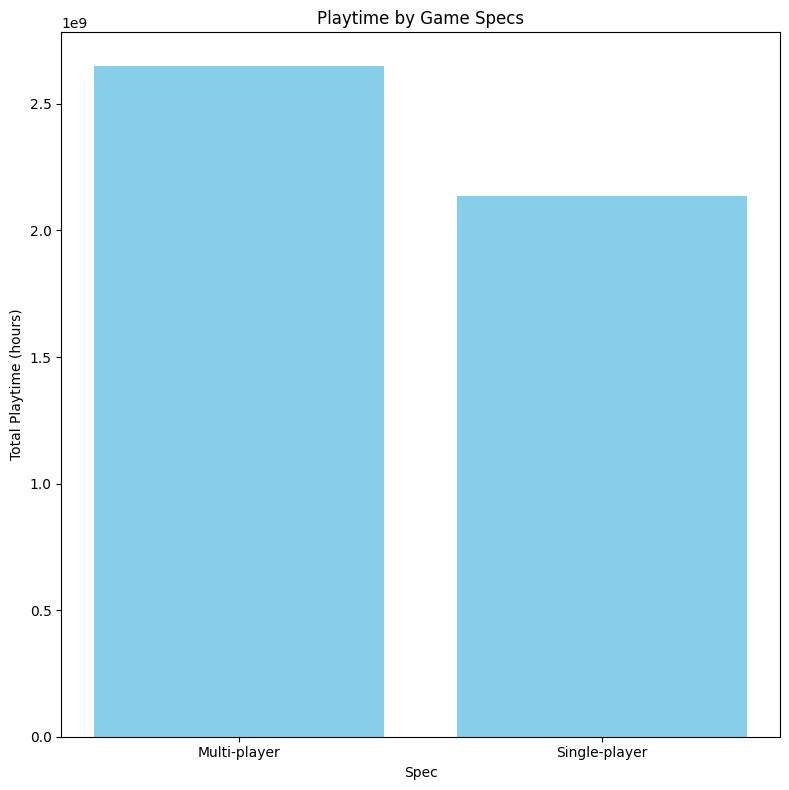

{'Multi-player': 2650248412, 'Single-player': 2134896363}
defaultdict(<class 'float'>, {'Action': 49248002358972.0, 'RPG': 9911978154775.0, 'Strategy': 2030138879139.0, 'Casual': 1700059394162.0, 'Simulation': 21177850448171.0, 'Indie': 29075668156026.0, 'Racing': 45907857586.0, 'Sports': 47615677868.0, 'Adventure': 9122284881864.0, 'Early Access': 1402572972189.0, 'Free to Play': 6827264877749.0, 'Massively Multiplayer': 3571837546433.0, 'Utilities': 1993525082.0, 'Animation &amp; Modeling': 145528812.0, 'Video Production': 161152354.0, 'Audio Production': 33371810.0, 'Software Training': 41388977.0, 'Design &amp; Illustration': 2798586074.0, 'Web Publishing': 2796918508.0, 'Photo Editing': 1969291.0, 'Education': 15160610.0})


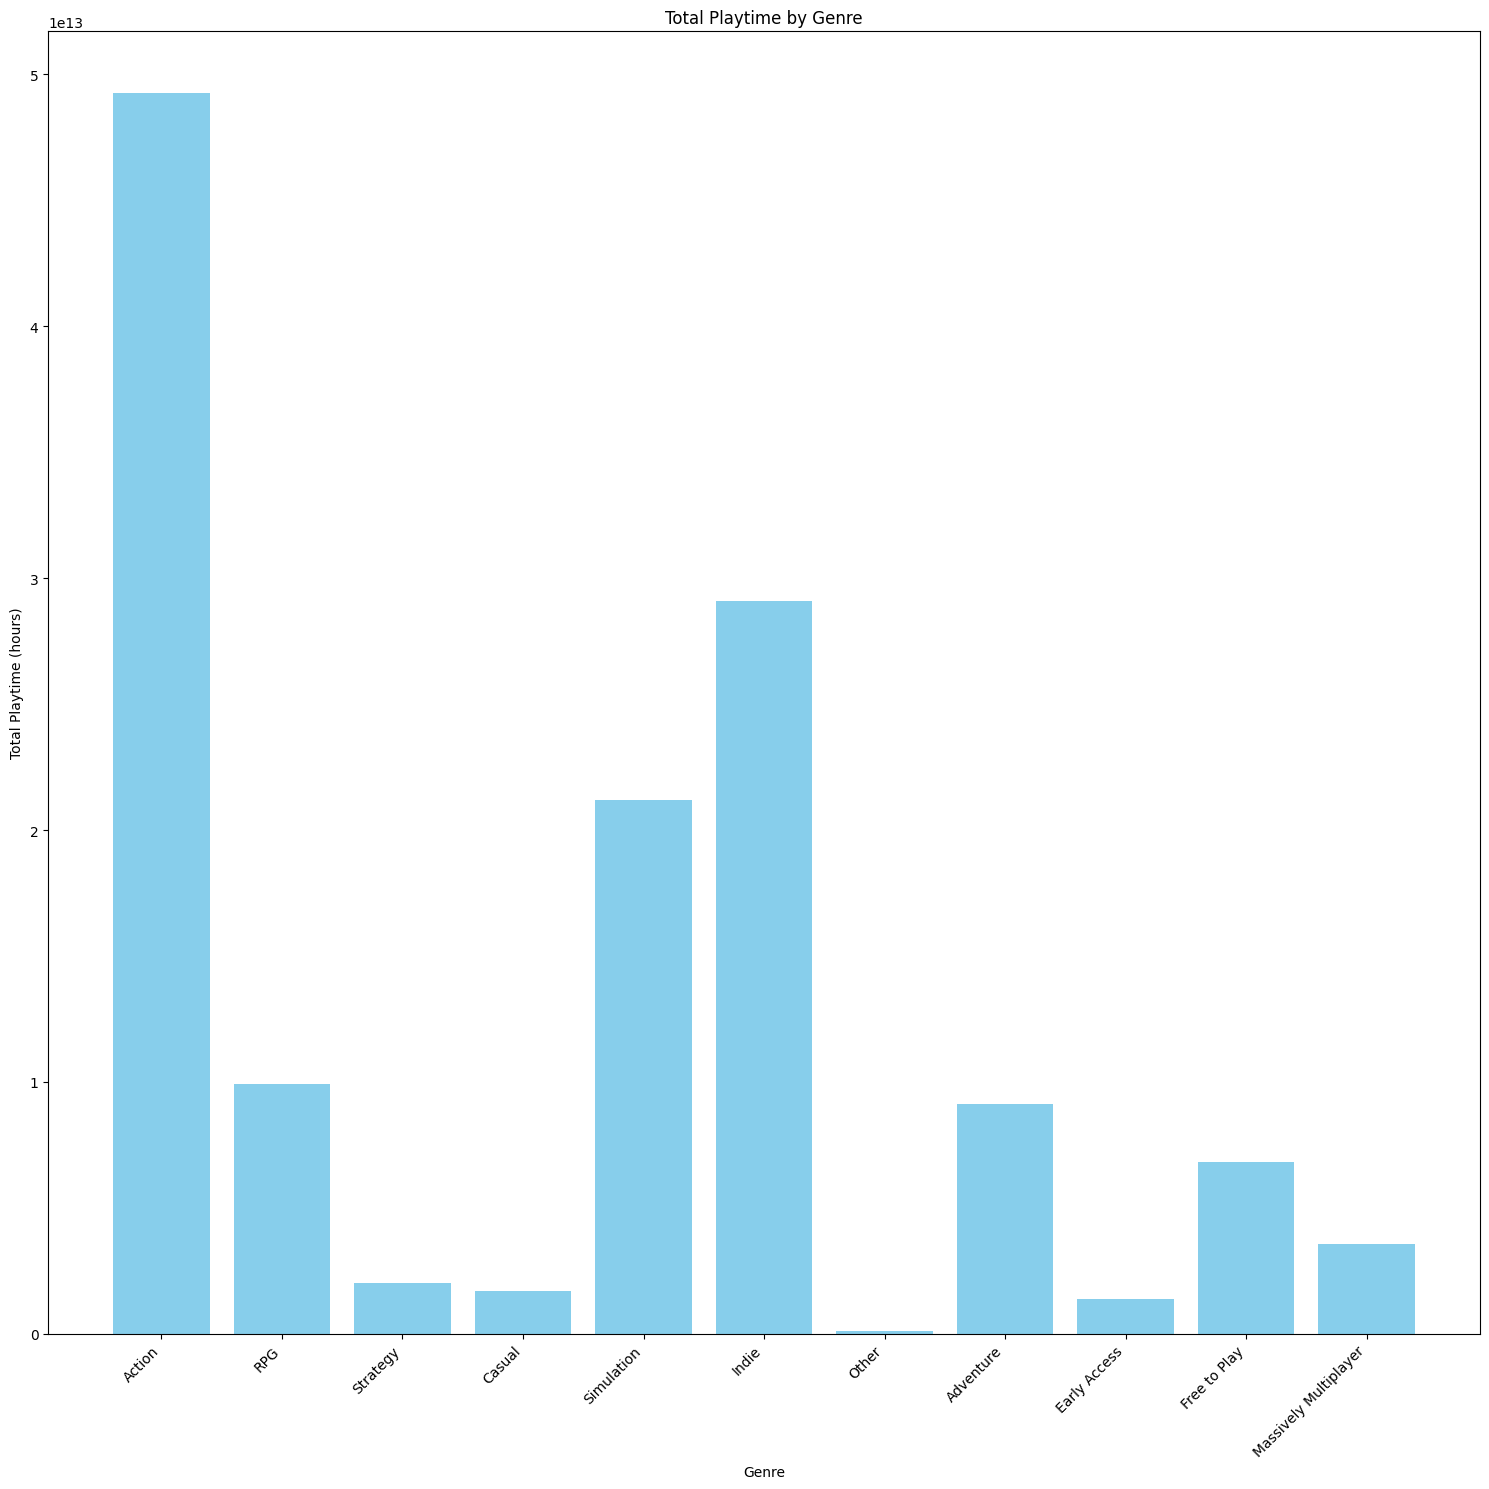

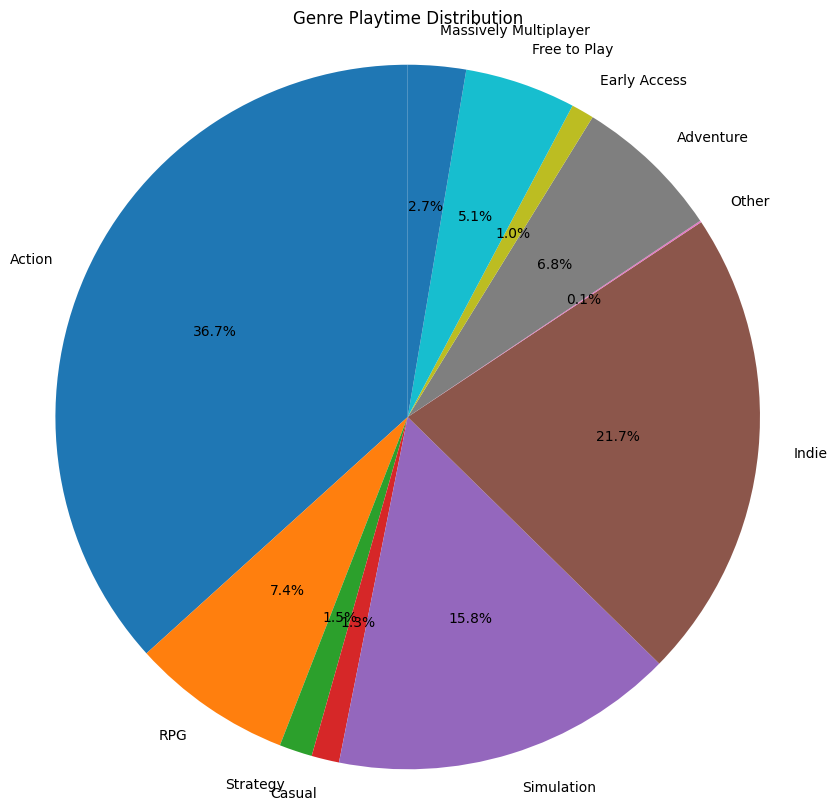

In [ ]:
import matplotlib.pyplot as plt

# Data preparation
# Sum total playtime for each genre
genre_playtime = defaultdict(float)
for user, games in genrePerGamePerUser.items():
    for game, genres in games:
        for genre in genres:
            genre_playtime[genre] += hoursPerGame[game]

# Sum total playtime for Multi-player vs Single-player
spec_count = {'Multi-player': 0, 'Single-player': 0}
mulitplayer_count = 0
singleplayer_count = 0
print(specsperGame.items())
for game, specs in specsperGame.items():
    hours = hoursPerGame.get(game, 0)

    if 'Multi-player' in specs:
        spec_count['Multi-player'] += hours
        mulitplayer_count += 1
    if 'Single-player' in specs:
        spec_count['Single-player'] += hours
        singleplayer_count +=1

print(mulitplayer_count)
print(singleplayer_count)
#spec_count['Multi-player'] /= mulitplayer_count
#spec_count['Single-player'] /= singleplayer_count
print(spec_count)

# Plotting pie chart for spec distribution
plt.figure(figsize=(8, 8))
#plt.pie(spec_count.values(), labels=spec_count.keys(), autopct='%1.1f%%', startangle=90)
plt.bar(spec_count.keys(), spec_count.values(), color='skyblue')
plt.title("Game Spec Distribution: Multi-player vs Single-player")
plt.title('Playtime by Game Specs')
plt.xlabel('Spec')
plt.ylabel('Total Playtime (hours)')
plt.tight_layout()
#plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular
plt.show()

print(spec_count)
#spec_playtime = {'Multi-player': 0, 'Single-player': 0}
#for user, specs in specsPerGamePerUser.items():
#    print(specs)
    #for game, specs_list in specs:
    #    if 'Multi-player' in specs_list:
    #        spec_playtime['Multi-player'] += hoursPerGame[game]
    #    if 'Single-player' in specs_list:
    #        spec_playtime['Single-player'] += hoursPerGame[game]

# Plot 1: Playtime by Genre
print(genre_playtime)
#plt.figure(figsize=(10, 5))
#genres = list(genre_playtime.keys())
#playtime = list(genre_playtime.values())
#plt.bar(genres, playtime, color='skyblue')
#plt.xticks(rotation=45, ha='right')
#plt.title('Total Playtime by Genre')
#plt.xlabel('Genre')
#plt.ylabel('Total Playtime (hours)')
#plt.tight_layout()
#plt.show()

# Plot 1: Playtime by Genre (Pie Chart)
threshold = 1e12  # Example threshold
grouped_data = defaultdict(float)

for category, value in genre_playtime.items():
    if value < threshold:
        grouped_data['Other'] += value
    else:
        grouped_data[category] = value

plt.figure(figsize=(15, 15))
genres = list(grouped_data.keys())
playtime = list(grouped_data.values())
plt.bar(genres, playtime, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Total Playtime by Genre')
plt.xlabel('Genre')
plt.ylabel('Total Playtime (hours)')
plt.tight_layout()
plt.show()

# Plot pie chart
plt.figure(figsize=(10, 10))
plt.pie(grouped_data.values(), labels=grouped_data.keys(), autopct='%1.1f%%', startangle=90)
plt.title("Genre Playtime Distribution")
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.show()


# Plot 2: Playtime by Specs (Multi-player vs Single-player)
#plt.figure(figsize=(6, 4))
#specs = list(spec_playtime.keys())
#playtime = list(spec_playtime.values())
#plt.bar(specs, playtime, color=['green', 'blue'])
#plt.title('Playtime by Game Specs')
#plt.xlabel('Spec')
#plt.ylabel('Total Playtime (hours)')
#plt.tight_layout()
#plt.show()

In [ ]:
# Feature vector setting

from collections import Counter, defaultdict
import numpy as np

# Initialize feature dictionaries
recent_popularity = defaultdict(int)
total_popularity = defaultdict(int)
average_playtime = defaultdict(float)
price_features = {}
genre_features = {}
specs_features = {}
tags_features = {}
sentiment_features = {}

# Populate recent and total popularity
# Assuming dataset has a 'timestamp' field for activity tracking
for user in userTrain:
    for item in user['items']:
        game = item['item_name']
        total_popularity[game] += 1
        if 'last_two_weeks' in item and item['last_two_weeks']:
            recent_popularity[game] += 1

# Populate average playtime
for user, games in hoursPerGamePerUser.items():
    for game, playtime in games:
        if game not in average_playtime:
            average_playtime[game] = []
        average_playtime[game].append(playtime)

average_playtime = {game: np.mean(times) for game, times in average_playtime.items()}

# Populate pricing, genres, specs, and tags
for game in gameTrain:
    if 'app_name' in game:
        game_name = game['app_name']
        price_features[game_name] = game.get('price', 0.0)
        genre_features[game_name] = game.get('genres', [])
        specs_features[game_name] = game.get('specs', [])
        tags_features[game_name] = game.get('tags', [])
        sentiment_features[game_name] = game.get('sentiment', None)

# Encode genres, specs, and tags into feature vectors
def encode_feature_list(feature_list, unique_features):
    encoded = np.zeros(len(unique_features))
    for feature in feature_list:
        if feature in unique_features:
            encoded[unique_features.index(feature)] = 1
    return encoded

# Get unique features
unique_genres = list({genre for genres in genre_features.values() for genre in genres})
unique_specs = list({spec for specs in specs_features.values() for spec in specs})
unique_tags = list({tag for tags in tags_features.values() for tag in tags})

# Construct feature vector for each game
feature_vectors = {}

for game in gameTrain:
    if 'app_name' in game:
        game_name = game['app_name']
        vector = [
            recent_popularity.get(game_name, 0),  # Recent Popularity
            total_popularity.get(game_name, 0),  # Popularity
            price_features.get(game_name, 0.0),  # Pricing
            *encode_feature_list(genre_features.get(game_name, []), unique_genres),  # Genre
            *encode_feature_list(specs_features.get(game_name, []), unique_specs),  # Specs
            *encode_feature_list(tags_features.get(game_name, []), unique_tags),  # Tags
            average_playtime.get(game_name, 0.0),  # Time
            sentiment_features.get(game_name, 0.0),  # Sentiment (Optional)
        ]
        feature_vectors[game_name] = vector

# Example: Print feature vector for a game
for game, vector in feature_vectors.items():
    print(f"Feature vector for {game}: {vector}")
    break  # Print one example


Feature vector for Lost Summoner Kitty: [0, 0, 4.99, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [ ]:
def base_prediction2(user, game):
  usergenres_per_game = genrePerGamePerUser[user]
  userspecs_per_game = specsPerGamePerUser[user]

  game_genre = genreperGame[game]
  if game_genre == []:
    if specsperGame[game]:
      acc = 0
      sim_count = 0
      acc_counts = []

      for game,gamesSpecs in userspecs_per_game:
        count = 0
        for specs in specsperGame[game]:
          if specs in gamesSpecs:
            count += 1
        acc_counts.append(count/len(specsperGame[game]))
      if len(acc_counts) == 0:
        return 0
      acc = sum(acc_counts) / len(acc_counts)
      if acc > 0.5:
        return 1
    else:
      return 0
  else:
    acc = 0
    sim_count = 0
    acc_counts = []

    for game,gamesGenre in usergenres_per_game:
      count = 0
      for genre in game_genre:
        if genre in gamesGenre:
          count += 1
      acc_counts.append(count/len(game_genre))
    if len(acc_counts) == 0:
      return 0
    acc = sum(acc_counts) / len(acc_counts)
    if acc > 0.2:
      return 1
  return 0

In [ ]:
hoursPerGenrePerUser["76561198329548331"]

defaultdict(int,
            {'Action': 720,
             'Adventure': 680,
             'Casual': 681,
             'Free to Play': 727,
             'Indie': 724,
             'Massively Multiplayer': 43,
             'Early Access': 0,
             0: 0})

In [ ]:
genreperGame.get('BrainBread 2', [])

['Action', 'Adventure', 'Free to Play', 'Indie', 'Early Access']

In [ ]:
def base_prediction3(user, game):
    usergenres_per_game = genrePerGamePerUser.get(user, [])
    userspecs_per_game = specsPerGamePerUser.get(user, [])

    game_genre = genreperGame.get(game, [])
    game_specs = specsperGame.get(game, [])
    game_sentiment = sentimentperGame.get(game, "")
    hoursPerGame2weeks.get(game, )

    def calculate_similarity(target_features, user_features):
        acc_counts = []
        for _, features in user_features:
            count = sum(1 for feature in target_features if feature in features)
            acc_counts.append(count / len(target_features) if target_features else 0)
        return sum(acc_counts) / len(acc_counts) if acc_counts else 0

    def check_sentiment(sentiment):
        # Define sentiment categories
        positive_sentiments = ["Very Positive", "Mostly Positive", "Overwhelmingly Positive", "Positive"]
        if sentiment in positive_sentiments:
            return True
        return False

    if game_genre:
        genres_for_game = game_genre
        genres_with_high_hours = {genre for genre, hours in hoursPerGenrePerUser[user].items() if hours > 20}
        matching_genres = [genre for genre in genres_for_game if genre in genres_with_high_hours]
        acc = calculate_similarity(game_genre, usergenres_per_game)
        acc2 = calculate_similarity(game_specs, userspecs_per_game)
        return 1 if acc > 0.3 or acc2 > 0.2 or len(matching_genres) >= 2 and check_sentiment(game_sentiment) else 0
    elif game_specs and check_sentiment(game_sentiment):
        acc = calculate_similarity(game_specs, userspecs_per_game)
        return 1 if acc > 0.2 else 0
    else:
        return 0

In [ ]:
def base_prediction3(user, game, genre_threshold=0.3, spec_threshold=0.3, genre_hours_threshold=40, min_matching_genres=2):
    # Retrieve user data
    usergenres_per_game = genrePerGamePerUser.get(user, [])
    userspecs_per_game = specsPerGamePerUser.get(user, [])

    # Retrieve game data
    game_genre = genreperGame.get(game, [])
    game_specs = specsperGame.get(game, [])
    game_sentiment = sentimentperGame.get(game, "")
    top_1200_games = list(hoursPerGame2weeks.keys())[:1200]
    #top_30_games_of_all_time = list(hoursPerGame2weeks.keys())[:20]

    # Ensure sentiment is a string, in case it's a list
    if isinstance(game_sentiment, list):
        game_sentiment = game_sentiment[0] if game_sentiment else ""

    def calculate_similarity(target_features, user_features):
        acc_counts = []
        for _, features in user_features:
            count = sum(1 for feature in target_features if feature in features)
            acc_counts.append(count / len(target_features) if target_features else 0)
        return sum(acc_counts) / len(acc_counts) if acc_counts else 0



    # Function to calculate weighted similarity based on playtime
    def calculate_weighted_similarity(game_genres, user_genres, user_hours):
        weighted_sim = 0
        total_hours = sum(user_hours.values())
        for genre in game_genres:
            if genre in user_genres:
                weighted_sim += (user_hours.get(genre, 0) / total_hours)  # Weight by playtime proportion
        return weighted_sim

    # Check if game has sentiment information
    def check_sentiment(sentiment):
        # Define sentiment categories
        positive_sentiments = ["Very Positive", "Mostly Positive", "Overwhelmingly Positive"]
        if sentiment in positive_sentiments:
            return True
        return False

    # If game genres exist, calculate similarity based on genres
    if game_genre:
        matching_genres = [genre for genre in game_genre if genre in hoursPerGenrePerUser[user] and hoursPerGenrePerUser[user][genre] > genre_hours_threshold]
        genre_sim = calculate_similarity(game_genre, usergenres_per_game)
        weighted_sim = calculate_weighted_similarity(game_genre, usergenres_per_game, hoursPerGenrePerUser[user])
        if game in top_1200_games:
          return 1
        if genre_sim > genre_threshold or weighted_sim > 0.20:
            if check_sentiment(game_sentiment):  # Check sentiment
                return 1  # Recommended based on genre similarity and sentiment
            else:
                return 0  # Not recommended based on sentiment

    # If game has specs, calculate similarity based on specs
    if game_specs:
        spec_sim = calculate_similarity(game_specs, userspecs_per_game)
        if spec_sim > spec_threshold:
            if check_sentiment(game_sentiment):  # Check sentiment
                return 1  # Recommended based on specs similarity and sentiment
            else:
                return 0  # Not recommended based on sentiment

    # If neither genre nor specs match, return 0 (not recommended)
    return 0


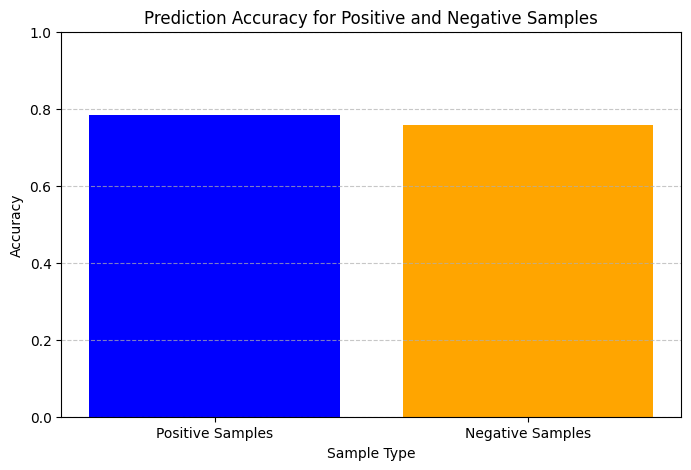

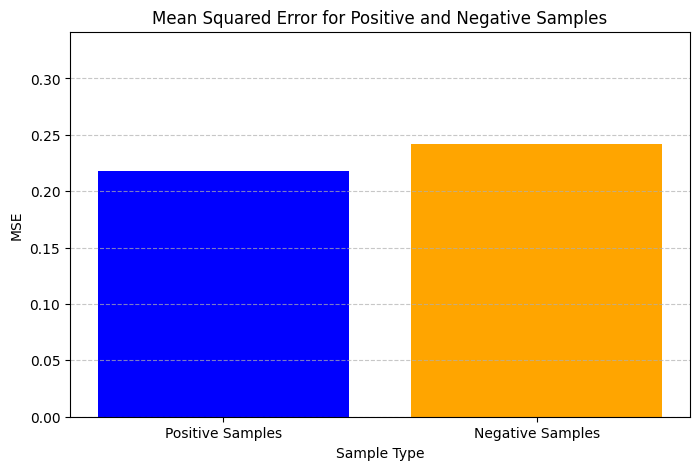

In [ ]:
import matplotlib.pyplot as plt

correct_counts = {1: 0, 0: 0}
total_counts = {1: 0, 0: 0}
squared_errors = {1: [], 0: []}  # Store squared errors for each label

# Define labels dynamically based on the data (for flexibility)
labels = [1, 0]

# Evaluate predictions and calculate MSE
for label in labels:
    samples = positive_samples if label == 1 else negative_samples
    for user_id, item_name, *_ in samples:
        pred = base_prediction3(user_id, item_name)  # Predict interaction

        # Track squared errors for MSE calculation
        squared_errors[label].append((label - pred) ** 2)

        if pred == label:
            correct_counts[label] += 1
        total_counts[label] += 1

# Calculate accuracy
accuracies = {
    label: (correct_counts[label] / total_counts[label] if total_counts[label] > 0 else 0)
    for label in labels
}

# Calculate MSE for each label
mse_values = {
    label: sum(squared_errors[label]) / len(squared_errors[label]) if squared_errors[label] else 0
    for label in labels
}

# Plot accuracy results
sample_labels = ['Positive Samples', 'Negative Samples']
accuracy_values = [accuracies[label] for label in labels]

plt.figure(figsize=(8, 5))
plt.bar(sample_labels, accuracy_values, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.title("Prediction Accuracy for Positive and Negative Samples")
plt.ylabel("Accuracy")
plt.xlabel("Sample Type")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot MSE results
mse_labels = ['Positive Samples', 'Negative Samples']
mse_values = [mse_values[label] for label in labels]

plt.figure(figsize=(8, 5))
plt.bar(mse_labels, mse_values, color=['blue', 'orange'])
plt.ylim(0, max(mse_values) + 0.1)
plt.title("Mean Squared Error for Positive and Negative Samples")
plt.ylabel("MSE")
plt.xlabel("Sample Type")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


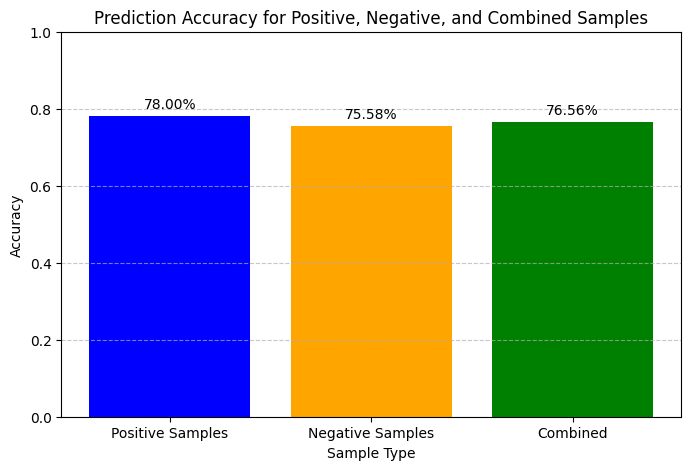

In [ ]:
# Calculate individual accuracies
accuracies = {
    label: (correct_counts[label] / total_counts[label] if total_counts[label] > 0 else 0)
    for label in [1, 0]
}

# Calculate combined accuracy
total_correct = sum(correct_counts.values())
total_samples = sum(total_counts.values())
combined_accuracy = total_correct / total_samples if total_samples > 0 else 0

# Data for plotting
categories = ['Positive Samples', 'Negative Samples', 'Combined']
values = [accuracies[1], accuracies[0], combined_accuracy]

# Plot the results
plt.figure(figsize=(8, 5))
plt.bar(categories, values, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)
plt.title("Prediction Accuracy for Positive, Negative, and Combined Samples")
plt.ylabel("Accuracy")
plt.xlabel("Sample Type")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display values above bars
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center')

plt.show()

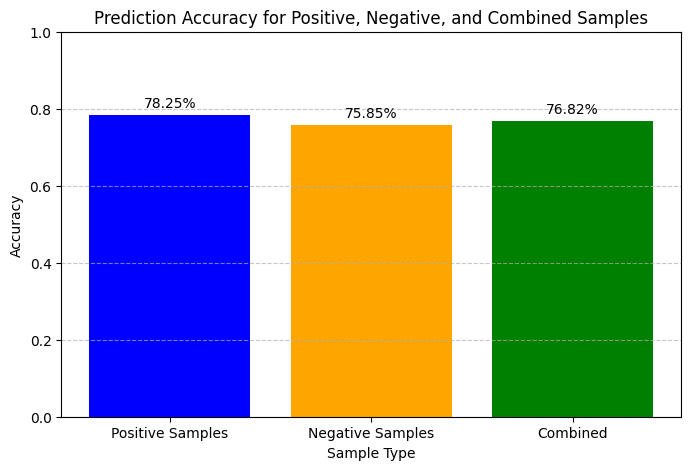

In [ ]:
# Calculate individual accuracies
accuracies = {
    label: (correct_counts[label] / total_counts[label] if total_counts[label] > 0 else 0)
    for label in [1, 0]
}

# Calculate combined accuracy
total_correct = sum(correct_counts.values())
total_samples = sum(total_counts.values())
combined_accuracy = total_correct / total_samples if total_samples > 0 else 0

# Data for plotting
categories = ['Positive Samples', 'Negative Samples', 'Combined']
values = [accuracies[1], accuracies[0], combined_accuracy]

# Plot the results
plt.figure(figsize=(8, 5))
plt.bar(categories, values, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)
plt.title("Prediction Accuracy for Positive, Negative, and Combined Samples")
plt.ylabel("Accuracy")
plt.xlabel("Sample Type")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display values above bars
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center')

plt.show()

In [ ]:
### Model 1 (SVD)

import numpy as np
from scipy.sparse.linalg import svds

# Step 1: Prepare the user-item matrix
# Rows = users, Columns = games, Values = playtime or interaction score
user_ids = list(gamesPerUser.keys())
game_ids = list(feature_vectors.keys())
print(user_ids)

# Create a mapping of user IDs and game names to indices
user_idx_map = {user: idx for idx, user in enumerate(user_ids)}
game_idx_map = {game: idx for idx, game in enumerate(game_ids)}

# Initialize the interaction matrix with zeros
user_item_matrix = np.zeros((len(user_ids), len(game_ids)))

# Populate the matrix with playtime data (or use ratings if available)
for user in gamesPerUser:
    for game, playtime in hoursPerGamePerUser[user]:
        if game in game_idx_map:
            user_idx = user_idx_map[user]
            game_idx = game_idx_map[game]
            user_item_matrix[user_idx, game_idx] = playtime

# Step 2: Perform SVD
# k is the number of latent factors
k = 50  # Adjust this based on the size of the data
U, sigma, Vt = svds(user_item_matrix, k=k)

# Convert sigma to a diagonal matrix
sigma = np.diag(sigma)

# Step 3: Reconstruct the matrix
predicted_matrix = np.dot(np.dot(U, sigma), Vt)

# Convert the predicted matrix back to user-game scores
user_game_predictions = {
    user_ids[u_idx]: {
        game_ids[g_idx]: predicted_matrix[u_idx, g_idx]
        for g_idx in range(len(game_ids))
    }
    for u_idx in range(len(user_ids))
}

# Step 4: Recommend top games for a user
def recommend_svd(user_id, top_n=5):
    if user_id not in user_game_predictions:
        return "User not found."
    predictions = user_game_predictions[user_id]
    # Sort games by predicted score
    sorted_games = sorted(predictions.items(), key=lambda x: x[1], reverse=True)
    # Filter out games the user already interacted with
    recommended_games = [
        game for game, score in sorted_games if game not in gamesPerUser[user_id]
    ]
    return recommended_games[:top_n]

# Example usage
example_user = user_ids[0]  # Replace with a valid user ID
print(f"Top recommendations for user {example_user}:", recommend_svd(example_user))


[]


ValueError: `A` must not be empty.

In [ ]:
correct = 0
total = 0
for (label, samples) in [(1, positive_samples), (0, negative_samples)]:
    for user_id, item_name, *_ in samples:  # Unpack only relevant fields
        pred = base_prediction3(user_id, item_name)
        if pred == label:
            correct += 1
        total += 1
accuracy = correct / total
print(f"Accuracy: {accuracy:.2%}")

KeyboardInterrupt: 

In [ ]:
correct_counts = {1: 0, 0: 0}
total_counts = {1: 0, 0: 0}

# Evaluate predictions
for (label, samples) in [(1, positive_samples), (0, negative_samples)]:
    for user_id, item_name, *_ in samples:
        pred = base_prediction3(user_id, item_name)  # Predict interaction
        if pred == label:
            correct_counts[label] += 1
        total_counts[label] += 1

# Calculate accuracy
accuracies = {
    label: (correct_counts[label] / total_counts[label] if total_counts[label] > 0 else 0)
    for label in [1, 0]
}

# Plot the results
labels = ['Positive Samples', 'Negative Samples']
values = [accuracies[1], accuracies[0]]

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.title("Prediction Accuracy for Positive and Negative Samples")
plt.ylabel("Accuracy")
plt.xlabel("Sample Type")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

KeyboardInterrupt: 